# a) Setup

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HancModel import HANCModelClass

In [2]:
model = HANCModelClass(name='baseline') # create an instance of the model

In [3]:
model.info()

settings:
 par.py_hh = False
 par.py_block = True
 par.full_z_trans = False
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [r,w_low,w_high,phi_low,phi_high]
 inputs_hh_z: []
 outputs_hh: [a,c,l_low,l_high,u]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [Gamma,phi_low,phi_high]
 unknowns: [K,L_low,L_high]
 targets: [clearing_A,clearing_L_low,clearing_L_high]

blocks (inputs -> outputs):
 production_firm: [Gamma,K,phi_low,phi_high,L_low,L_high] -> [rK,w_low,w_high,Y]
 mutual_fund: [K,rK] -> [A,r]
 hh: [phi_high,phi_low,r,w_high,w_low] -> [A_hh,C_hh,L_LOW_hh,L_HIGH_hh,U_hh]
 market_clearing: [A,A_hh,L_low,L_high,L_HIGH_hh,L_LOW_hh,Y,C_hh,K] -> [I,clearing_A,clearing_L_low,clearing_L_high,clearing_Y]


production_firm: [Gamma,K,phi_low,phi_high,L_low,L_high] -> [rK,w_low,w_high,Y]
mutual_fund: [K,rK] -> [A,r]
hh: [phi_high,phi_low,r,w_high,w_low] -> [A_hh,C_hh,L_LOW_hh,L_HIGH_hh,U_hh]
market_clearing: [A,A_hh,L_low,L_high,L_HIGH_hh,L_LOW_hh,Y,C_hh,K] -> [I,clearing_A,clearing_L_low,clearing_L_high,clearing_Y]


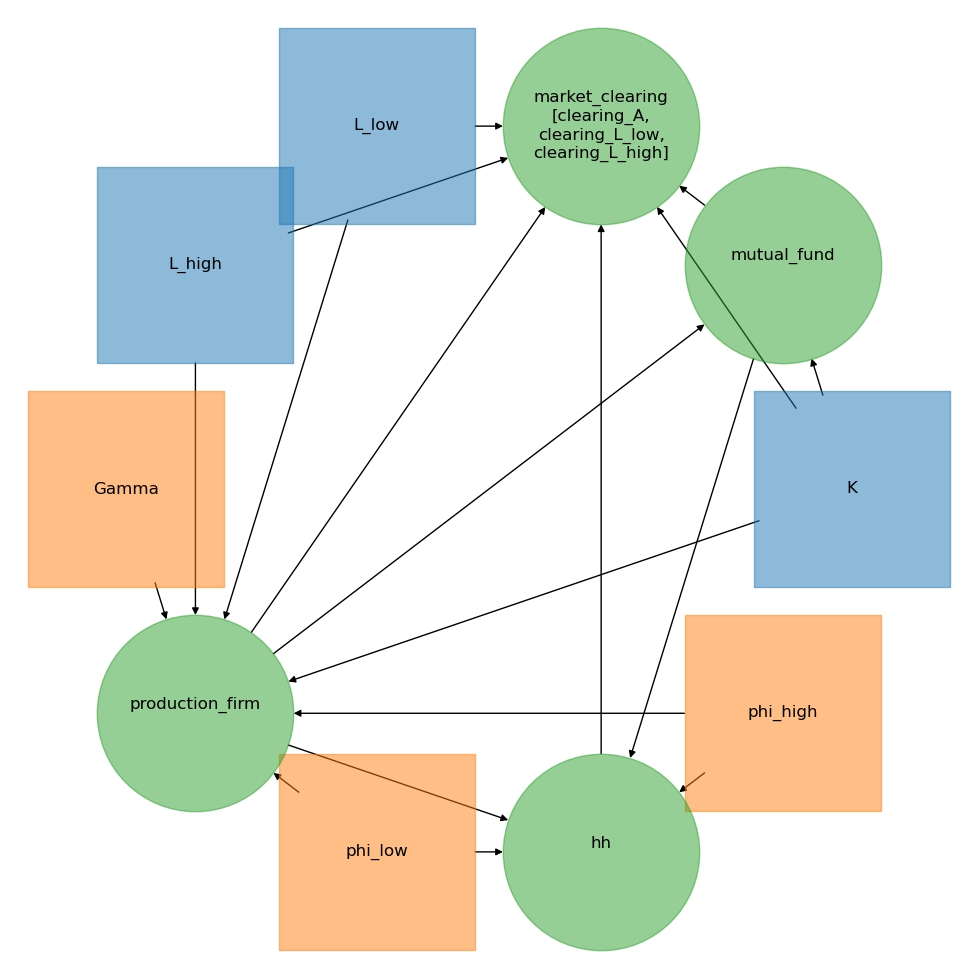

In [4]:
model.info(only_blocks=True)
model.draw_DAG(figsize=(10,10))

# b) Solve for stationary equilibrium

In [5]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

In [6]:
# Calibration parameters
ss.phi_high = 2.0
ss.phi_low = 1.0
# Some guesses for the steady state for households
ss.rK = 0.05
ss.r = 0.05
ss.w_high = 1.5
ss.w_low = 1.0

In [7]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 7.8 secs [853 iterations]
household problem in ss simulated in 5.0 secs [1172 iterations]


In [8]:
model.find_ss(do_print=True)

### step 1: broad search ###

guess ss.K = 1.0000
implied ss.r = 0.1777
implied ss.w_low = 0.3703
implied ss.w_high = 0.3703
household problem in ss solved in 0.8 secs [339 iterations]
household problem in ss simulated in 0.0 secs [113 iterations]
implied ss.A_hh = 535.9821
clearing_A = -534.98213157

guess ss.K = 2.0000
implied ss.r = 0.0782
implied ss.w_low = 0.4752
implied ss.w_high = 0.4752
household problem in ss solved in 0.8 secs [618 iterations]
household problem in ss simulated in 0.2 secs [374 iterations]
implied ss.A_hh = 512.8555
clearing_A = -510.85553541

guess ss.K = 3.0000
implied ss.r = 0.0375
implied ss.w_low = 0.5499
implied ss.w_high = 0.5499
household problem in ss solved in 1.7 secs [1029 iterations]
household problem in ss simulated in 18.0 secs [13957 iterations]
implied ss.A_hh = 502.9870
clearing_A = -499.98702119

guess ss.K = 4.0000
implied ss.r = 0.0144
implied ss.w_low = 0.6099
implied ss.w_high = 0.6099
household problem in ss solved in 2.2 secs [1726 ite

In [9]:
# look at the steady state.
for varname in model.varlist:
    print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')

Gamma          : 1.0000
K              : 4.1098
rK             : 0.1124
w_low          : 0.6159
w_high         : 0.6159
Y              : 1.2831
phi_low        : 1.0000
phi_high       : 2.0000
L_low          : 0.6667
L_high         : 0.6667
A              : 4.1098
r              : 0.0124
A_hh           : 4.1098
C_hh           : 0.8722
L_LOW_hh       : 0.6667
L_HIGH_hh      : 0.6667
U_hh           : -1.8721
I              : 0.4110
clearing_A     : -0.0000
clearing_L_low : 0.0000
clearing_L_high: 0.0000
clearing_Y     : 0.0000


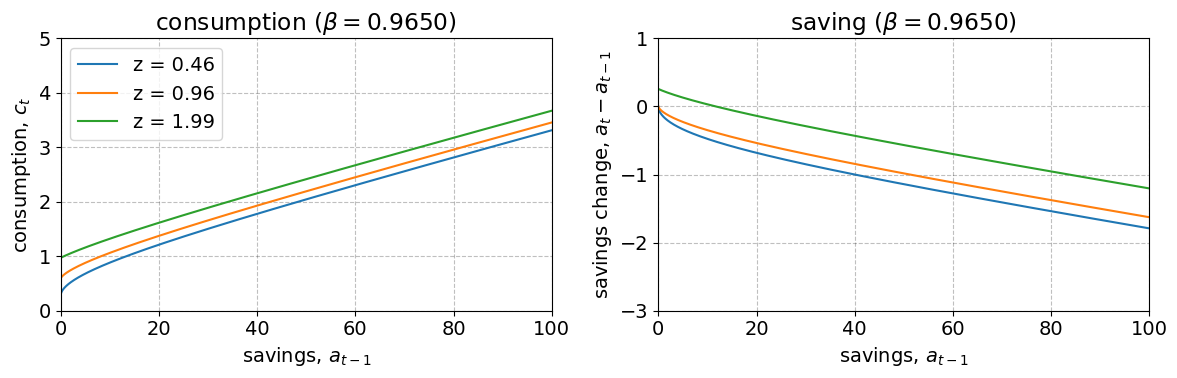

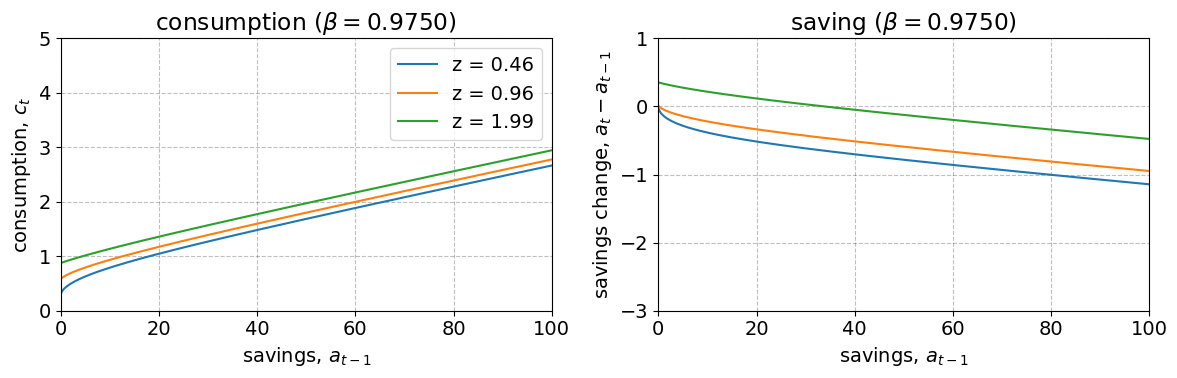

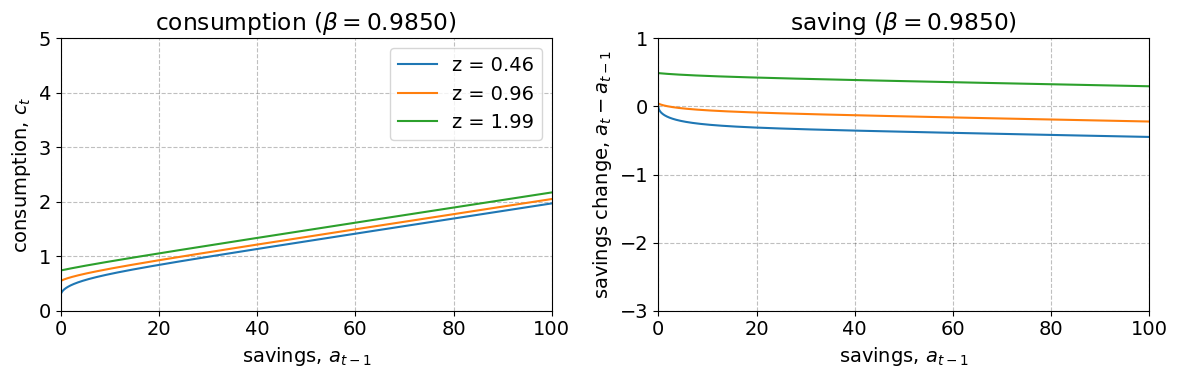

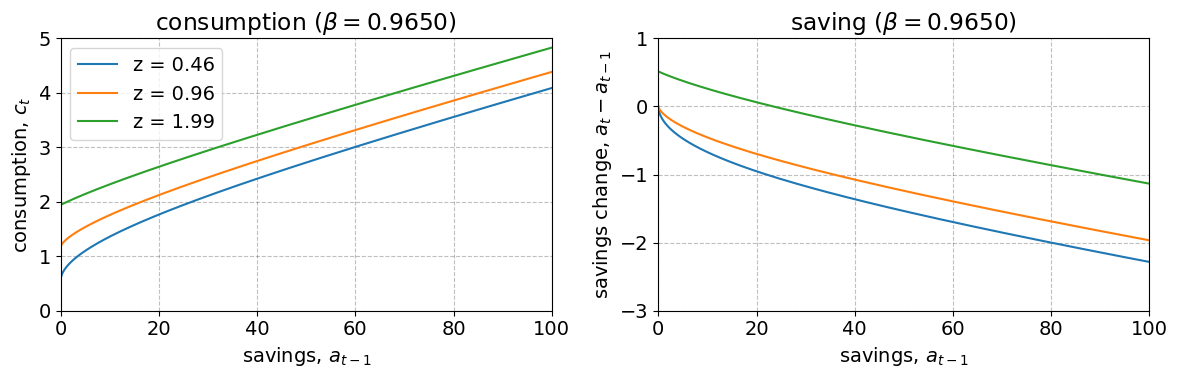

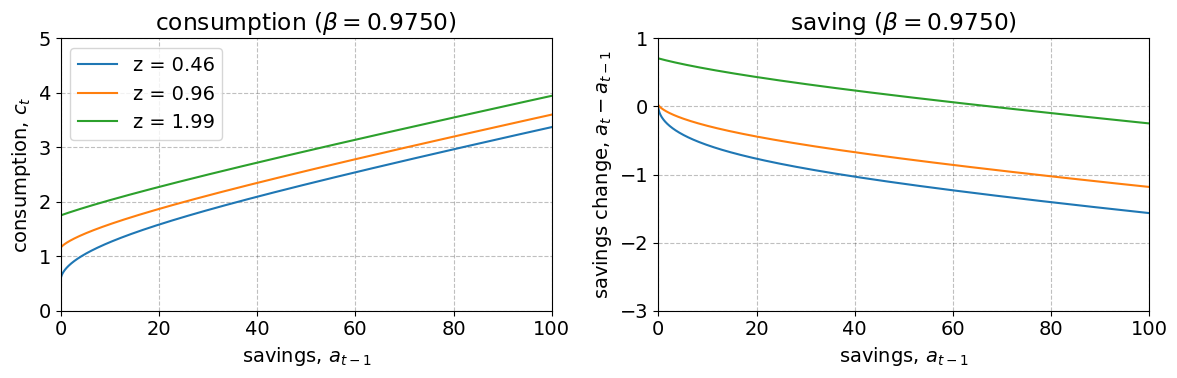

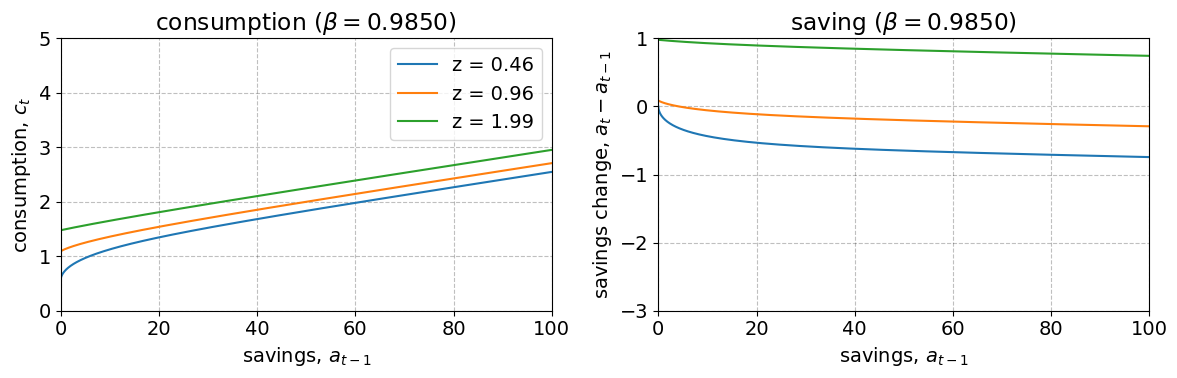

In [10]:
# policy functions
for i_beta,beta in enumerate(par.beta_grid[:]):
    
    fig = plt.figure(figsize=(12,4),dpi=100)

    I = par.a_grid < 500

    # a. consumption
    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.c[i_beta,i_z,I],label=f'z = {z:.2f}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')
    ax.set_xlim(0,100)
    ax.set_ylim(0,5)

    # b. saving
    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.a[i_beta,i_z,I]-par.a_grid[I],label=f'z = {z:.2f}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')
    ax.set_xlim(0,100)
    ax.set_ylim(-3,1)

    fig.tight_layout()

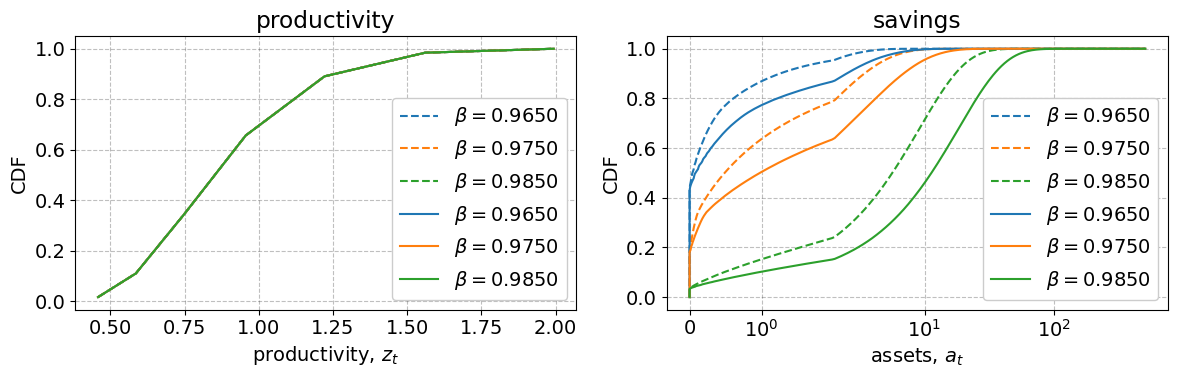

In [11]:
fig = plt.figure(figsize=(12,4),dpi=100)
# color map with a unique color for each beta value
cmap = plt.get_cmap('tab10')

# dictionary to store colors for each beta value
color_dict = {}

# a. income
ax = fig.add_subplot(1, 2, 1)
ax.set_title('productivity')
for i_beta, beta in enumerate(par.beta_grid[:]):
    if i_beta < 3:  # low productivity type
        cdf = np.cumsum(np.sum(ss.D[i_beta], axis=1))
        cdf /= cdf[-1]  # normalize
        color = color_dict.setdefault(beta, cmap(len(color_dict)))
        ax.plot(par.z_grid, cdf, label=f'$\\beta = {beta:.4f}$', linestyle='--', color=color)
    else:  # high productivity type
        color = color_dict[beta] 
        cdf = np.cumsum(np.sum(ss.D[i_beta], axis=1))
        cdf /= cdf[-1]  # normalize
        ax.plot(par.z_grid, cdf, label=f'$\\beta = {beta:.4f}$', linestyle='-', color=color)
ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')
ax.legend(framealpha=1)

# b. assets
ax = fig.add_subplot(1, 2, 2)
ax.set_title('savings')
for i_beta in range(par.Nfix):
    if i_beta < 3:
        cdf = np.cumsum(np.sum(ss.D[i_beta], axis=0))
        cdf /= cdf[-1]  # normalize
        color = color_dict[par.beta_grid[i_beta]]  
        ax.plot(np.insert(par.a_grid, 0, par.a_grid[0]), np.insert(cdf, 0, 0.0), label=f'$\\beta = {par.beta_grid[i_beta]:.4f}$', linestyle='--', color=color)
    else:
        color = color_dict[par.beta_grid[i_beta]] 
        cdf = np.cumsum(np.sum(ss.D[i_beta], axis=0))
        cdf /= cdf[-1]  # normalize
        ax.plot(np.insert(par.a_grid, 0, par.a_grid[0]), np.insert(cdf, 0, 0.0), label=f'$\\beta = {par.beta_grid[i_beta]:.4f}$', linestyle='-', color=color)
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')
ax.legend(framealpha=1)

fig.tight_layout()


# c) Compute and inspect Jacobians of the household wrt. $\phi_1$

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.3 secs
household problem simulated along transition in 1.7 secs



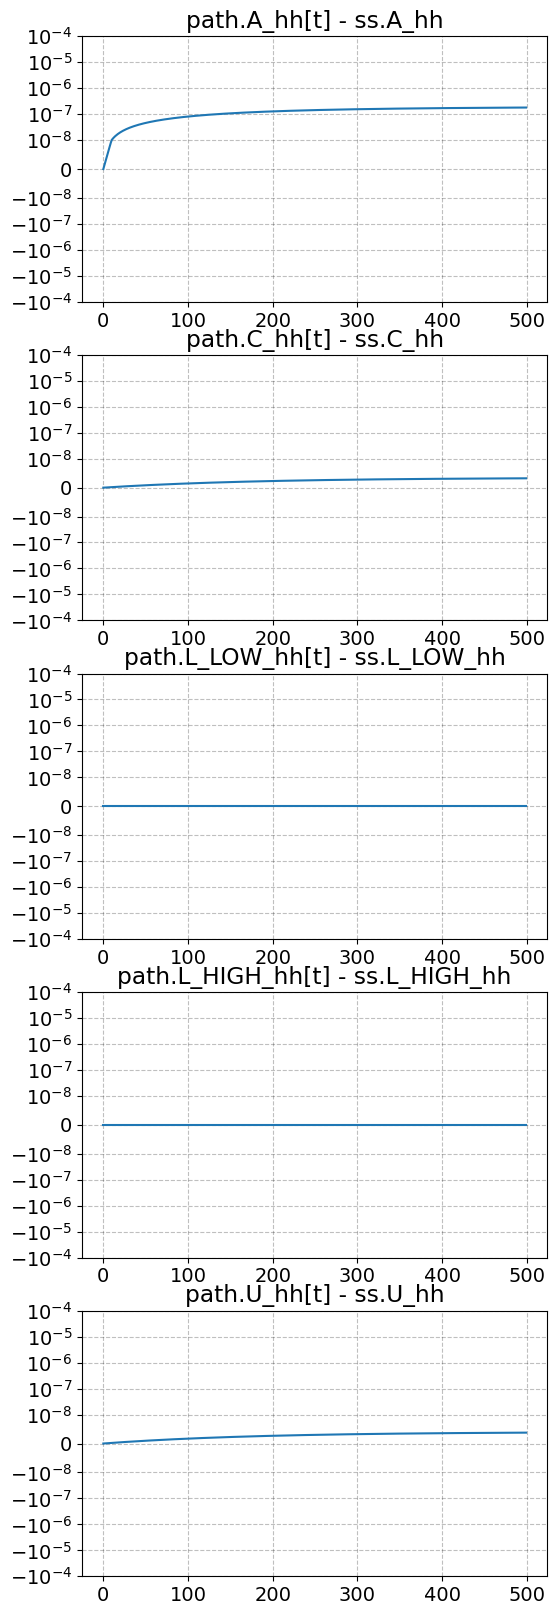

In [12]:
# look if behavior is as expected
model.test_hh_path()

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 0 125 250 375 [computed in 2.8 secs]
finding Jacobian wrt. phi_high       : 0 125 250 375 [computed in 3.1 secs]
finding Jacobian wrt. phi_low        : 0 125 250 375 [computed in 2.8 secs]
finding Jacobian wrt. r              : 0 125 250 375 [computed in 2.6 secs]
finding Jacobian wrt. w_high         : 0 125 250 375 [computed in 3.3 secs]
finding Jacobian wrt. w_low          : 0 125 250 375 [computed in 2.7 secs]
household Jacobian computed in 17.7 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for phi_high        in 1.4 secs
curly_Y and curly_D calculated for phi_low         in 1.4 secs
curly_Y and curly_D calculated for r               in 1.2 secs
curly_Y and curly_D calculated for w_high          in 3.4 secs
curly_Y and curly_D calculated for w_low           in 2.5 secs
curly_E calculated in 5.6 secs
buili

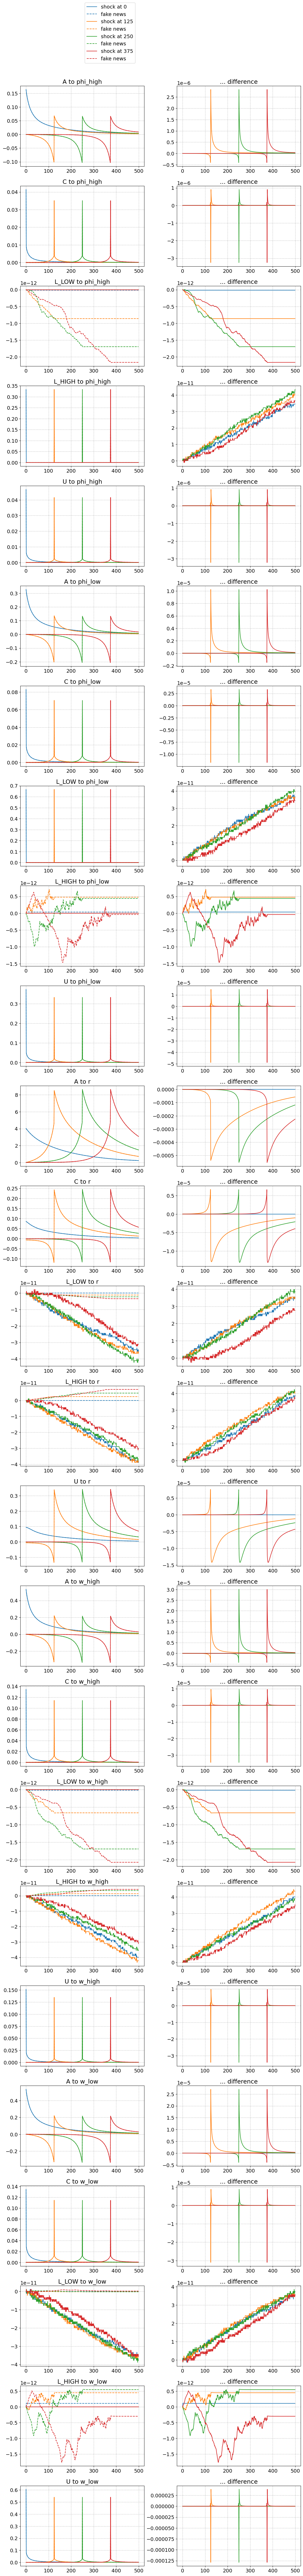

In [13]:
model.test_jacs()

In [14]:
model.test_path()

shocks: Gamma phi_low phi_high 
unknowns: K L_low L_high 

blocks.production_firm
 rK               0.0e+00
 w_low            0.0e+00
 w_high           0.0e+00
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                0.0e+00
hh
 A_hh             1.8e-07
 C_hh             3.2e-09
 L_LOW_hh         1.8e-15
 L_HIGH_hh        2.1e-15
 U_hh             3.8e-09
blocks.market_clearing
 I                    nan
 clearing_A       1.8e-07 [target]
 clearing_L_low   1.8e-14 [target]
 clearing_L_high  2.0e-14 [target]
 clearing_Y       3.2e-09


In [15]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for phi_high        in 2.7 secs
curly_Y and curly_D calculated for phi_low         in 1.5 secs
curly_Y and curly_D calculated for r               in 1.7 secs
curly_Y and curly_D calculated for w_high          in 1.7 secs
curly_Y and curly_D calculated for w_low           in 2.3 secs
curly_E calculated in 1.8 secs
builiding blocks combined in 1.7 secs
household Jacobian computed in 13.5 secs

full Jacobians:
full Jacobian to unknowns computed in 1.8 secs [in evaluate_blocks(): 0.9 secs]
full Jacobian to shocks computed in 1.6 secs [in evaluate_blocks(): 0.8 secs]


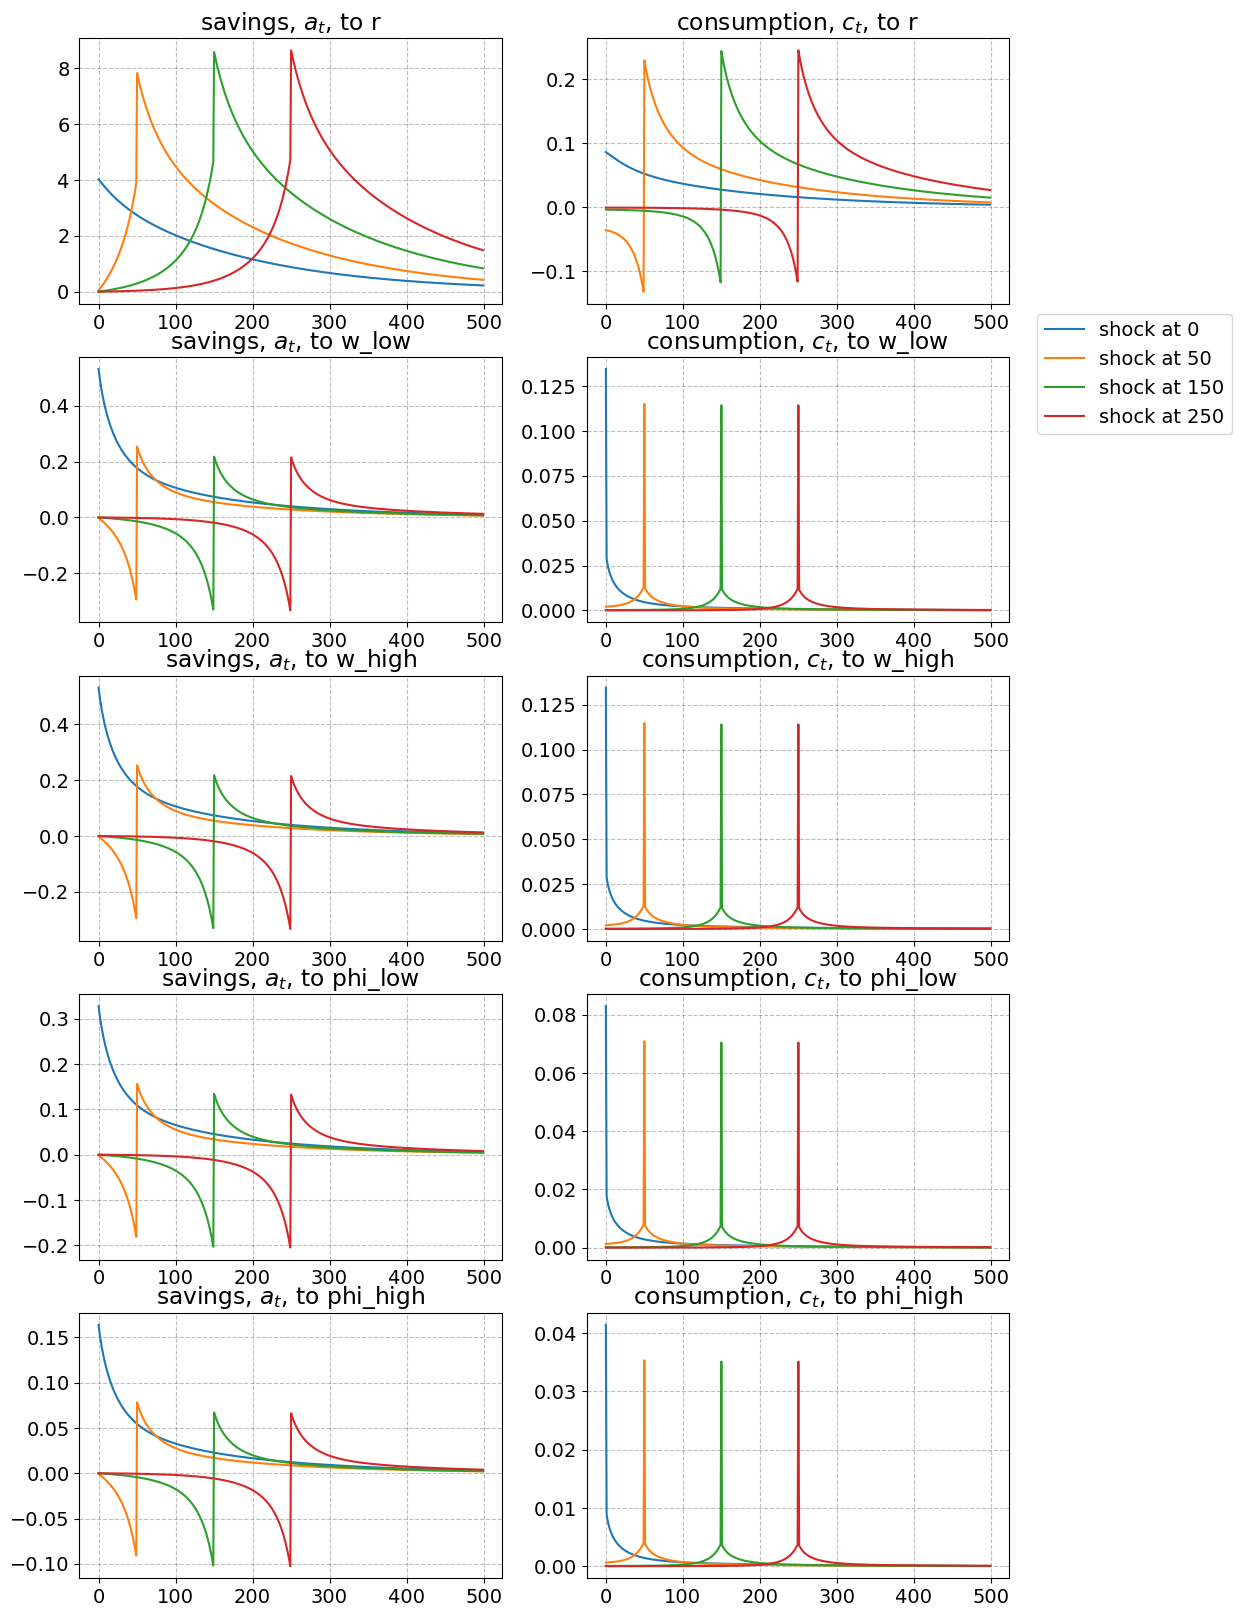

In [16]:
# plot the jacobians
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    
    if i == 1:
        ax.legend(frameon=True,bbox_to_anchor=(2.75,0.0))

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')

# d) Solve for the transition path when $\phi_{1t}$ is 10 percent higher for 10 periods

In [17]:
model.test_path()

shocks: Gamma phi_low phi_high 
unknowns: K L_low L_high 

blocks.production_firm
 rK               0.0e+00
 w_low            0.0e+00
 w_high           0.0e+00
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                0.0e+00
hh
 A_hh             1.8e-07
 C_hh             3.2e-09
 L_LOW_hh         1.8e-15
 L_HIGH_hh        2.1e-15
 U_hh             3.8e-09
blocks.market_clearing
 I                    nan
 clearing_A       1.8e-07 [target]
 clearing_L_low   1.8e-14 [target]
 clearing_L_high  2.0e-14 [target]
 clearing_Y       3.2e-09


In [18]:
# a. define shock
dphi_high = np.zeros(par.T)
dphi_high[10:21] = 0.1*ss.phi_high
shocks = {'dphi_high':dphi_high} 

# b. find transition path
model.find_transition_path(do_print=True,shocks=shocks)

finding the transition path:
 it =   0 -> max. abs. error = 3.61e-01
   3.61e-01 in clearing_A
   2.21e-14 in clearing_L_low
   6.67e-02 in clearing_L_high
 it =   1 -> max. abs. error = 6.97e-03
   6.97e-03 in clearing_A
   3.33e-16 in clearing_L_low
   7.55e-15 in clearing_L_high
 it =   2 -> max. abs. error = 2.34e-04
   2.34e-04 in clearing_A
   4.44e-16 in clearing_L_low
   2.22e-16 in clearing_L_high
 it =   3 -> max. abs. error = 2.06e-06
   2.06e-06 in clearing_A
   5.55e-16 in clearing_L_low
   6.66e-16 in clearing_L_high
 it =   4 -> max. abs. error = 1.13e-08
   1.13e-08 in clearing_A
   2.22e-16 in clearing_L_low
   4.44e-16 in clearing_L_high
 it =   5 -> max. abs. error = 3.22e-11
   3.22e-11 in clearing_A
   4.44e-16 in clearing_L_low
   6.66e-16 in clearing_L_high
I: terminal value is   0.00000000, but ss value is   0.41098044

transition path found in 11.1 secs


### shocks ###


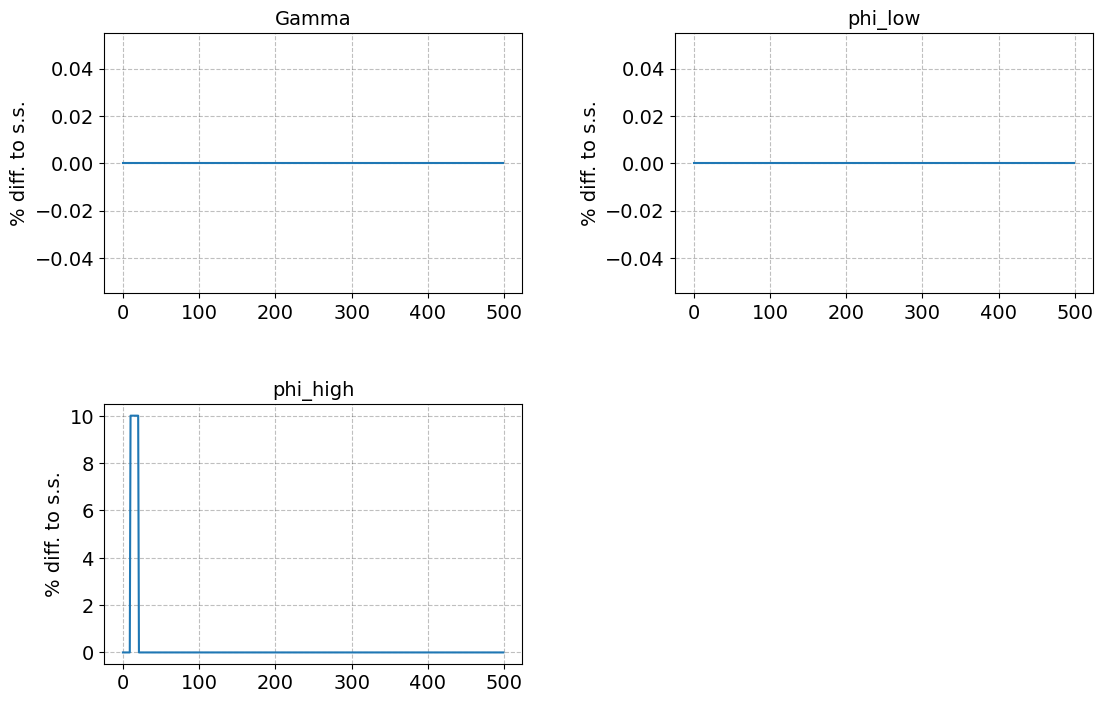


### varnames ###


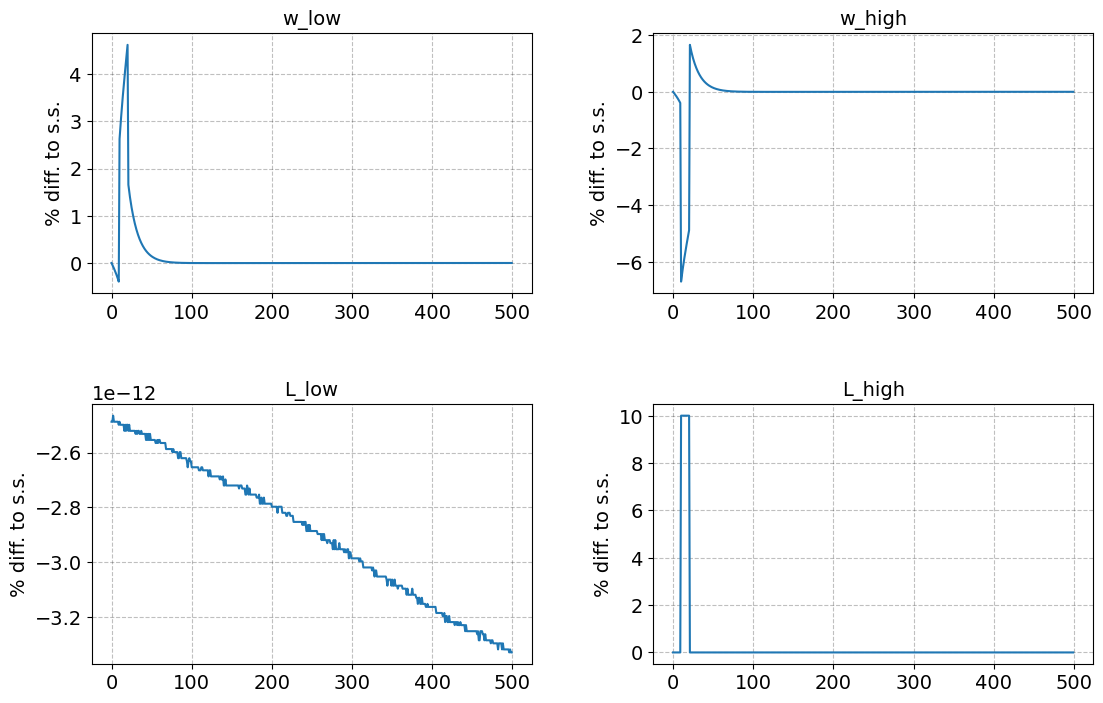


### tagets ###


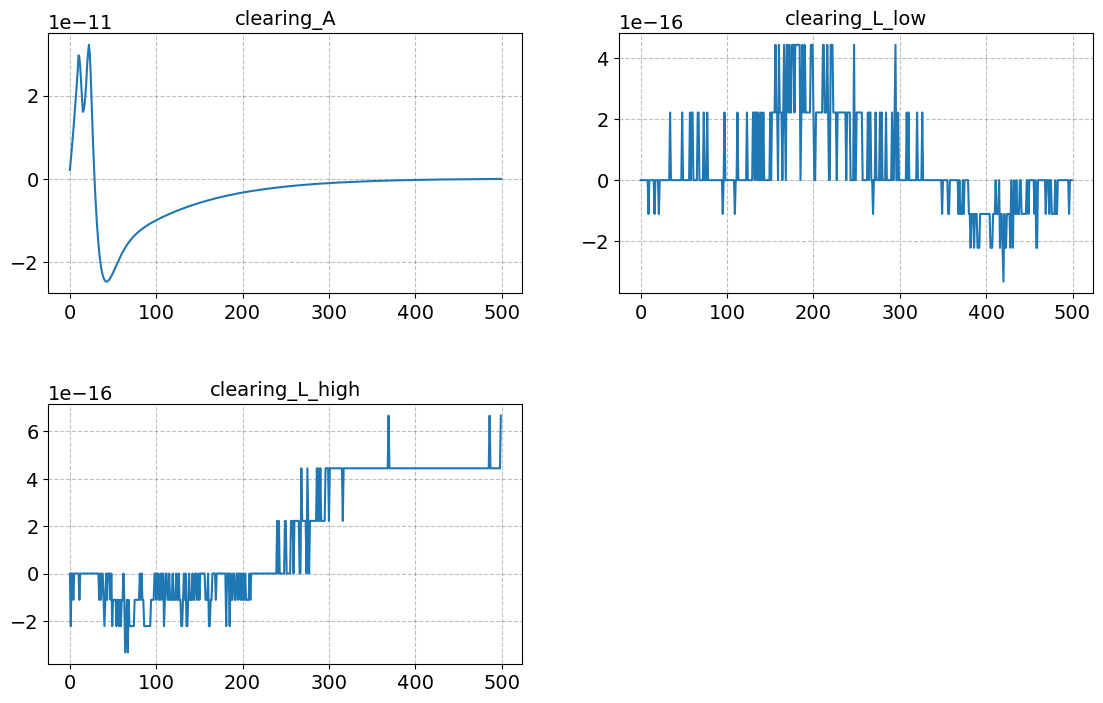

In [19]:
model.show_IRFs(varnames=['w_low','w_high','L_low','L_high'],ncols=2)

In [20]:
for i_fix in range(par.Nfix):
    v = np.sum([model.par.beta_grid[i_fix]**t*np.sum(model.path.u[t,i_fix]*model.path.D[t,i_fix]/np.sum(model.path.D[t,i_fix]))
    for t in range(model.par.T)])

    v_ss = np.sum([model.par.beta_grid[i_fix]**t*np.sum(model.ss.u[i_fix]*model.ss.D[i_fix]/np.sum(model.ss.D[i_fix]))
    for t in range(model.par.T)])
    
    print(f'for beta = {model.par.beta_grid[i_fix]}: v_ss = {v_ss}, v = {v}: v-v_ss = {v-v_ss}')

for beta = 0.965: v_ss = -64.24221690396324, v = -63.754197264810614: v-v_ss = 0.4880196391526255
for beta = 0.975: v_ss = -88.13443557304358, v = -87.5615352644393: v-v_ss = 0.5729003086042752
for beta = 0.985: v_ss = -132.44529103069019, v = -131.9012151838278: v-v_ss = 0.5440758468623983
for beta = 0.965: v_ss = -39.26412877237996, v = -39.02011385532498: v-v_ss = 0.24401491705498302
for beta = 0.975: v_ss = -54.06767441826226, v = -53.78121323673785: v-v_ss = 0.2864611815244089
for beta = 0.985: v_ss = -82.8813820540489, v = -82.60933520155668: v-v_ss = 0.27204685249222393


# e) Solve for the transition path when $\phi_{1t}$ is permanently 10 percent higher

In [21]:
model_new = HANCModelClass(name='permanent shock') 
model_new.ss.phi_high = (1+0.1)*2.0
model_new.par.phi_high = (1+0.1)*2.0

model_new.find_ss(do_print=True)


### step 1: broad search ###

guess ss.K = 1.0000
implied ss.r = 0.1863
implied ss.w_low = 0.3818
implied ss.w_high = 0.3471
household problem in ss solved in 0.5 secs [321 iterations]
household problem in ss simulated in 0.0 secs [107 iterations]
implied ss.A_hh = 537.9423
clearing_A = -536.94230599

guess ss.K = 2.0000
implied ss.r = 0.0837
implied ss.w_low = 0.4900
implied ss.w_high = 0.4454
household problem in ss solved in 0.7 secs [587 iterations]
household problem in ss simulated in 0.1 secs [314 iterations]
implied ss.A_hh = 514.1788
clearing_A = -512.17878337

guess ss.K = 3.0000
implied ss.r = 0.0417
implied ss.w_low = 0.5670
implied ss.w_high = 0.5154
household problem in ss solved in 1.1 secs [958 iterations]
household problem in ss simulated in 2.3 secs [3193 iterations]
implied ss.A_hh = 504.0470
clearing_A = -501.04702804

guess ss.K = 4.0000
implied ss.r = 0.0179
implied ss.w_low = 0.6288
implied ss.w_high = 0.5717
household problem in ss solved in 3.5 secs [1568 iterat

In [22]:
for varname in model_new.varlist:
    print(f'{varname:15s}: {model_new.ss.__dict__[varname]:.4f}')

Gamma          : 1.0000
K              : 4.3104
rK             : 0.1124
w_low          : 0.6460
w_high         : 0.5872
Y              : 1.3458
phi_low        : 1.0000
phi_high       : 2.2000
L_low          : 0.6667
L_high         : 0.7333
A              : 4.3104
r              : 0.0124
A_hh           : 4.3104
C_hh           : 0.9147
L_LOW_hh       : 0.6667
L_HIGH_hh      : 0.7333
U_hh           : -1.8083
I              : 0.4310
clearing_A     : 0.0000
clearing_L_low : 0.0000
clearing_L_high: 0.0000
clearing_Y     : 0.0000


In [23]:
model.test_path()

shocks: Gamma phi_low phi_high 
unknowns: K L_low L_high 

blocks.production_firm
 rK               0.0e+00
 w_low            0.0e+00
 w_high           0.0e+00
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                0.0e+00
hh
 A_hh             1.8e-07
 C_hh             3.2e-09
 L_LOW_hh         1.8e-15
 L_HIGH_hh        2.1e-15
 U_hh             3.8e-09
blocks.market_clearing
 I                    nan
 clearing_A       1.8e-07 [target]
 clearing_L_low   1.8e-14 [target]
 clearing_L_high  2.0e-14 [target]
 clearing_Y       3.2e-09


In [24]:
model_new.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for phi_high        in 6.6 secs
curly_Y and curly_D calculated for phi_low         in 1.2 secs
curly_Y and curly_D calculated for r               in 1.3 secs
curly_Y and curly_D calculated for w_high          in 1.2 secs
curly_Y and curly_D calculated for w_low           in 1.2 secs
curly_E calculated in 1.3 secs
builiding blocks combined in 1.6 secs
household Jacobian computed in 14.4 secs

full Jacobians:
full Jacobian to unknowns computed in 1.7 secs [in evaluate_blocks(): 0.8 secs]
full Jacobian to shocks computed in 1.6 secs [in evaluate_blocks(): 0.8 secs]


In [25]:
# find transition path
model_new.find_transition_path(do_print=True,shocks=[],ini=model.ss.__dict__)

finding the transition path:
 it =   0 -> max. abs. error = 1.96e-01
   1.96e-01 in clearing_A
   2.28e-14 in clearing_L_low
   2.66e-14 in clearing_L_high
 it =   1 -> max. abs. error = 1.24e-03
   1.24e-03 in clearing_A
   4.44e-16 in clearing_L_low
   4.44e-16 in clearing_L_high
 it =   2 -> max. abs. error = 1.62e-05
   1.62e-05 in clearing_A
   3.33e-16 in clearing_L_low
   4.44e-16 in clearing_L_high
 it =   3 -> max. abs. error = 3.02e-08
   3.02e-08 in clearing_A
   3.33e-16 in clearing_L_low
   3.33e-16 in clearing_L_high
 it =   4 -> max. abs. error = 2.51e-10
   2.51e-10 in clearing_A
   3.33e-16 in clearing_L_low
   4.44e-16 in clearing_L_high
 it =   5 -> max. abs. error = 3.69e-13
   3.69e-13 in clearing_A
   4.44e-16 in clearing_L_low
   4.44e-16 in clearing_L_high
I: terminal value is   0.00000000, but ss value is   0.43103963

transition path found in 9.2 secs


### shocks ###


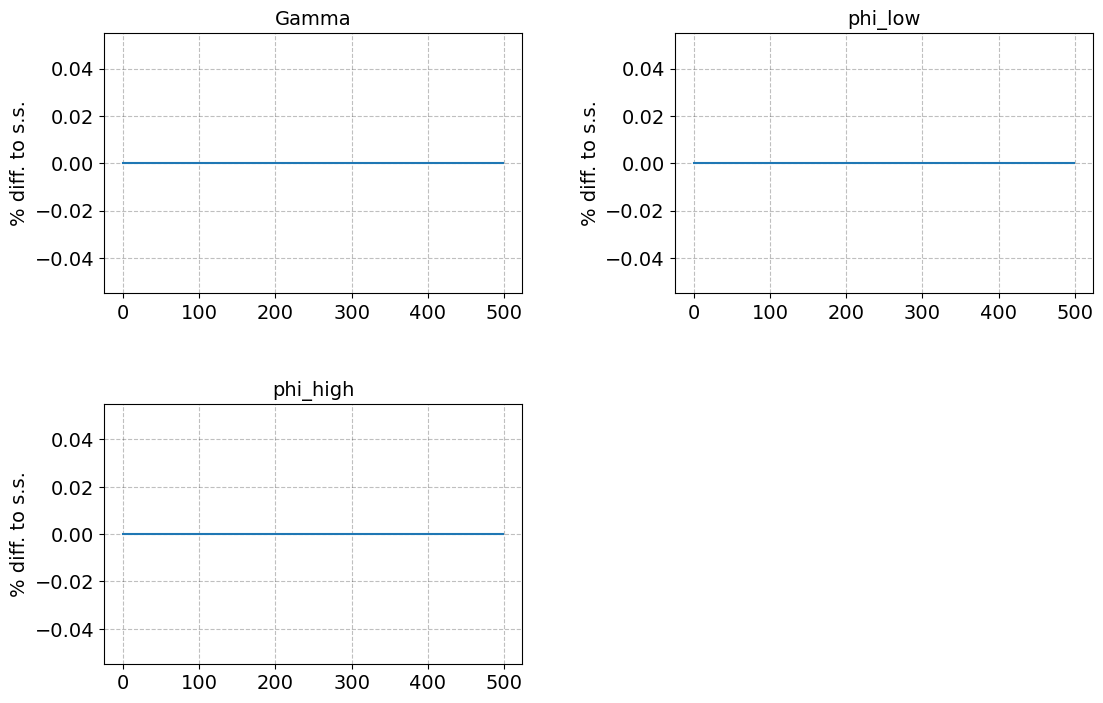


### varnames ###


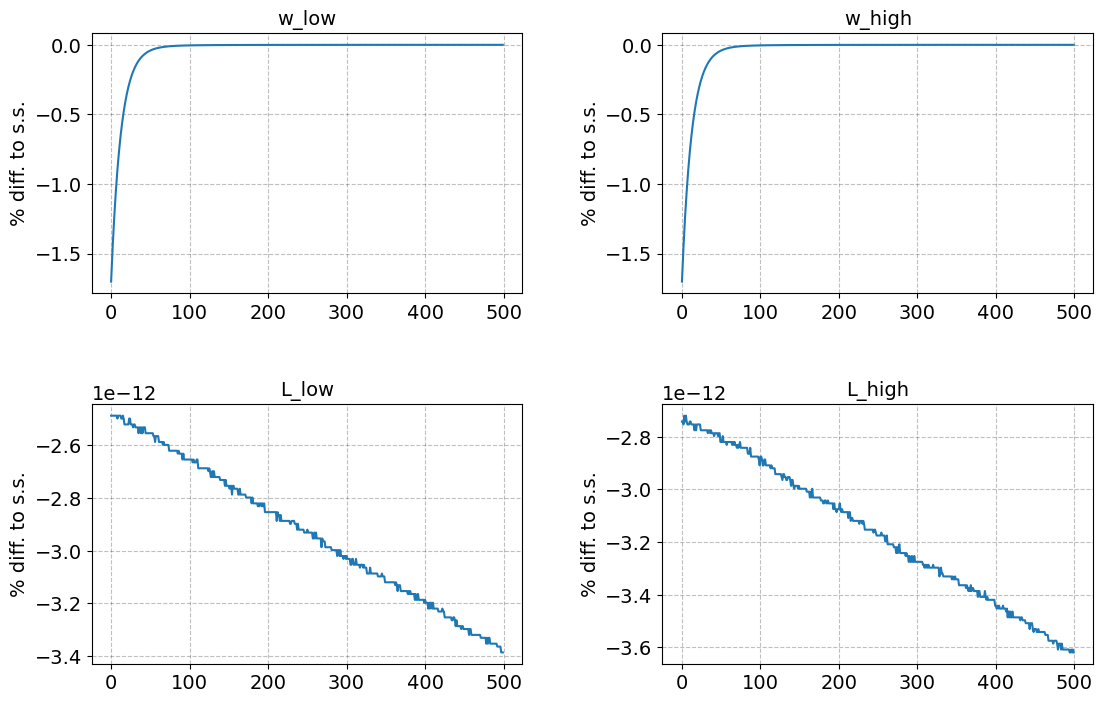


### tagets ###


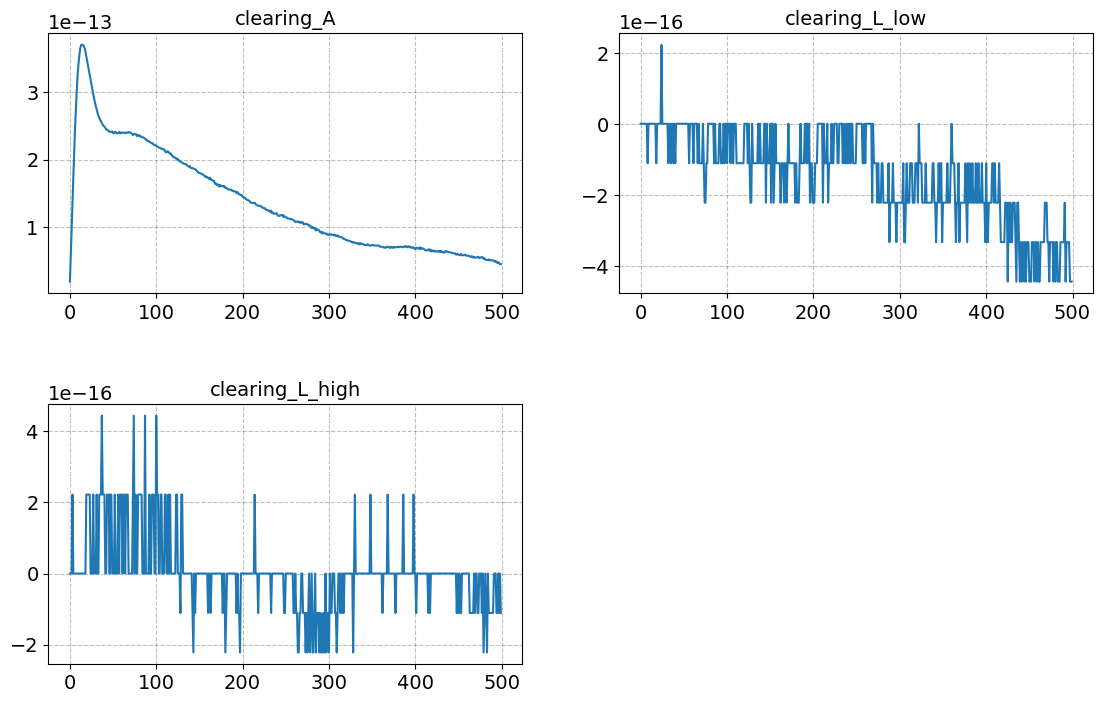

In [26]:
model_new.show_IRFs(varnames=['w_low','w_high','L_low','L_high'],ncols=2)

In [27]:
for i_fix in range(par.Nfix):
    v = np.sum([model_new.par.beta_grid[i_fix]**t*np.sum(model_new.path.u[t,i_fix]*model_new.path.D[t,i_fix]/np.sum(model_new.path.D[t,i_fix]))
    for t in range(model_new.par.T)])

    v_ss = np.sum([model_new.par.beta_grid[i_fix]**t*np.sum(model_new.ss.u[i_fix]*model_new.ss.D[i_fix]/np.sum(model_new.ss.D[i_fix]))
    for t in range(model_new.par.T)])
    
    print(f'for beta = {model_new.par.beta_grid[i_fix]}: v_ss = {v_ss}, v = {v}: v_ss-v = {v_ss-v}')

for beta = 0.965: v_ss = -61.917389179459455, v = -62.18911797847613: v_ss-v = 0.2717287990166781
for beta = 0.975: v_ss = -84.96373253224873, v = -85.26441819339388: v_ss-v = 0.3006856611451525
for beta = 0.985: v_ss = -127.83198186441359, v = -128.1800485223341: v_ss-v = 0.34806665792049785
for beta = 0.965: v_ss = -38.10170011546933, v = -38.23757205737281: v_ss-v = 0.13587194190348129
for beta = 0.975: v_ss = -52.482255493638355, v = -52.632651305638205: v_ss-v = 0.15039581199985008
for beta = 0.985: v_ss = -80.57467027885508, v = -80.74873768088017: v_ss-v = 0.17406740202508786
